### This is a playground to experiment code

In [16]:
import math
import numpy as np
import matplotlib.pyplot as plt
import graphviz

from typing import Union

In [7]:
a = 5
b = 9
c = 10

y = a * b + c

print(y)

55


In [45]:
class Value:
    def __init__(self, data, prevs=[], ops='', label=''): # data should be simple numeric value (e.g. int or float)
        self.data = data
        self.prevs = prevs
        self.ops = ops
        self.grad = 0.0
        self.label = label
    
    def __repr__(self):
        return str(f'Value(data: {self.data})')
    
    def __add__(self, other):
        return Value(self.data + other.data, [self, other], '+')
    
    def __mul__(self, other):
        return Value(self.data * other.data, [self, other], '*')
    
    def id(self):
        return str(id(self)) 

In [49]:
a = Value(5, label='a')
b = Value(9, label='b')
c = Value(10, label='c')
d = a * b; d.label = 'd'
y = d + c; y.label='y'

print(y)

Value(data: 55)


### Helper to visualize the computation graph

In [41]:
def trace(root):
    nodes = []
    edges = []
    def DFS(node):
        if node in nodes:
            return
        nodes.append(node)
        for prev in node.prevs:
            edges.append((prev, node))
            DFS(prev)
    DFS(root)
    return nodes, edges

print(trace(y))

([Value(data: 55), Value(data: 45), Value(data: 5), Value(data: 9), Value(data: 10)], [(Value(data: 45), Value(data: 55)), (Value(data: 5), Value(data: 45)), (Value(data: 9), Value(data: 45)), (Value(data: 10), Value(data: 55))])


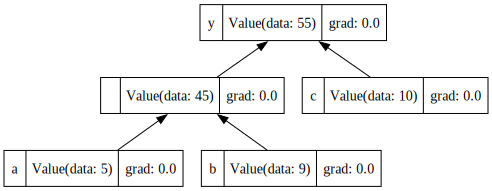

In [50]:
def generate_graph(nodes, edges):
    def node_label(node):
        return f'{node.label} | {str(node)} | grad: {node.grad}'

    dot = graphviz.Digraph()
    dot.attr(rankdir='BT')
    for node in nodes:
        dot.node(node.id(), node_label(node), shape='record')

    for edge in edges:
        dot.edge(edge[0].id(), edge[1].id())
    
    return dot

dot = generate_graph(*trace(y))
dot